In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate, shift
from astropy import stats

In [164]:
def add_gauss(im, mu_x, mu_y, sigma_x, sigma_y, theta, A):
    x, y = np.meshgrid(range(im.shape[0]), range(im.shape[1]))
    a = np.cos(theta)**2/(2*sigma_x**2) + np.sin(theta)**2/(2*sigma_y**2)
    b = -np.sin(2*theta)/(4*sigma_x**2) + np.sin(2*theta)/(4*sigma_y**2)
    c = np.sin(theta)**2/(2*sigma_x**2) + np.cos(theta)**2/(2*sigma_y**2)
    g = A*np.exp(-(a*(x-mu_x)**2 + 2*b*(x-mu_x)*(y-mu_y) + c*(y-mu_y)**2)) # 2D Gaussian general formula (pixel values)
    return im + g

def add_asym_gauss(im, mu_x, mu_y, sigma_x, sigma_y, theta, A, d, e):
    '''
    Adds an asymmetric Gaussian (different sigmas on either side of peak)
    around the peak (mu_x, mu_y), at angle theta to the vertical
    '''
    # sets dimensions to be odd, so is a central pixel for rotation about
    x_dim_, y_dim_ = im.shape[0]//2*2-1, im.shape[1]//2*2-1
    # otherwise can cause unwanted asymmetries in image when multiple Gaussians (i.e.tails)
    x, y = np.meshgrid(range(x_dim_), range(y_dim_)) # pixel coordinates
    
    #d, e = sigma values either side of peak
    
    a = 1/(2*sigma_x**2)
    c = np.empty_like(y, dtype=float)
    c[y>y_dim_//2] = 1/(2*(d*sigma_y)**2)
    c[y<=y_dim_//2] = 1/(2*(e*sigma_y)**2)
    
    g = A*np.exp(-(a*(x-y_dim_//2)**2 + c*(y-y_dim_//2)**2)) # 2D Gaussian function
    g = rotate(g, theta*180/np.pi, reshape=False) # rotate so at correct angle
    g = shift(g, [mu_y-y_dim_//2, mu_x-x_dim_//2]) # shift peak from center to (mu_x, mu_y)
    g = np.pad(g, [[0,y_dim_%2],[0,x_dim_%2]], mode='constant') # pad array so same dimensions as im
    return im + g

def add_noise(im):
    x_dim, y_dim = im.shape
    return im + 0.05*np.random.rand(x_dim,y_dim)
    
def normalise(im):
    return 2*(im-np.min(im))/np.ptp(im)-1 # [-1,1]

def parab_sim_agn():
    '''
    Create a random simulated AGN
    Using a parabola to define variables
    '''
    # Generate quadratic curve and pixel coords of two opposite points
    dim = 70 # image dimension
    cent_x, cent_y = np.random.normal(dim//2,2,2) # black hole location
    a = np.random.rand(1)/10 # quadratic curve parameter
    a = 0.01
    quad = lambda x: a*(x-cent_x)**2 + cent_y # curve function
    n = 100
    x = np.linspace(0, dim, n)
    d = np.random.rand(1)*(dim/2)*(2/3) + 4 # distance of jets centre from black hole
    # Jets can extend to 2/3 of the image size, but have to 4 pixels away from centre

    # Calculates pixel coords of jets centres
    diff = d - np.sqrt((x-cent_x)**2 + (quad(x)-cent_y)**2)
    idx = [np.argmin(np.abs(diff[:n//2])), np.argmin(np.abs(diff[n//2:]))+n//2]
    tail_x, tail_y = np.around(x[idx]), np.around(quad(x)[idx])

    # Calculate gradients of curve at jet centres -> ang of tails
    thetas = np.arctan(1/np.gradient(quad(x),x)[idx])
    
    # Create blank image and add black hole and tails at calculated coords
    image = np.zeros((dim, dim))
    A = np.random.rand(1)+0.5
    image = add_asym_gauss(image, tail_x[0], tail_y[0], 1.5, 1.6, thetas[0], A, 1, 2.4)
    image = add_asym_gauss(image, tail_x[1], tail_y[1], 1.5, 1.6, thetas[1], A+np.random.normal(0,0.1), 1, 2.4)
    image = add_gauss(image, cent_x, cent_y, 1.5, 1.5, 0, np.random.rand())
    #image = add_noise(image)
    image = normalise(image)
    return image

def sim_agn(fr_type=1, rot=True):
    '''
    Create a random simulated AGN
    Using a bending angle to define variables
    Can specify fr1 or fr2 or bent (3)
    '''
    dim = 56 # image dimension
    
    # Random variables
    cent_x, cent_y = np.random.normal(dim//2, scale=3, size=2) # black hole location
    if fr_type == 3:
        angle = np.random.rand()*np.pi*8/9 + np.pi/9 # from 20-180 degrees
        fr_type = np.random.randint(2)+1
    else:
        angle = np.random.rand()*np.pi/18
    c1 = np.random.rand()*0.5+0.8
    ratio = np.random.rand()*1.2+1
    c2 = c1*ratio
    
    if fr_type==1:
        d = np.random.rand()*(dim/2)*0.2 + 3 # distance of jets centre from black hole
        tail_halo_sigma = np.random.rand()*2.5
        tail_halo_brightness = np.random.rand()
    if fr_type==2:
        d = np.random.rand()*(dim/2)*0.5 + 4 # distance of jets centre from black hole
        tail_halo_sigma = np.random.rand()*4+1
        tail_halo_brightness = np.random.rand()
    halo_kw = [tail_halo_sigma, tail_halo_sigma, 0, tail_halo_brightness]
    
    # tail locations
    tail1_x = cent_x - d
    tail1_y = cent_y
    tail2_x = cent_x + d*np.cos(angle)
    tail2_y = cent_y + d*np.sin(angle)
    
    # Create blank image and add black hole and tails at calculated coords
    image = np.zeros((dim, dim))
    A = np.random.rand(1)+0.5
    image = add_asym_gauss(image, tail1_x, tail1_y, 1.5, 2.5, (-1)**fr_type*(-np.pi/2), A, c1, c2)
    image = add_asym_gauss(image, tail2_x, tail2_y, 1.5, 2.5, (-1)**fr_type*(np.pi/2)-angle, A+np.random.normal(0,0.1), c1, c2)
    image = add_gauss(image, cent_x, cent_y, 1.5, 1.5, 0, np.random.rand())
    image = add_gauss(image, tail1_x, tail1_y, *halo_kw)
    image = add_gauss(image, tail2_x, tail2_y, *halo_kw)
    #image = add_noise(image)
    image = normalise(image)
    if rot: image = rotate(image, np.random.rand()*360, reshape=False, cval=-1)
    return image, angle*180/np.pi

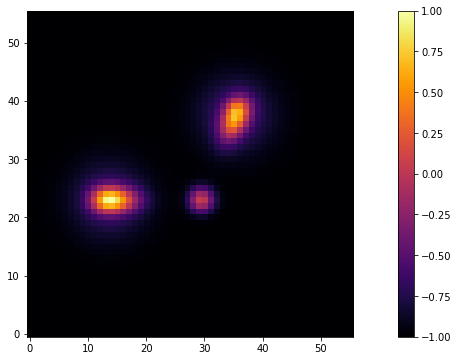

In [187]:
plt.figure(figsize=(16,6))
plt.imshow(sim_agn(fr_type=3, rot=False)[0], origin='lower', cmap='inferno')
#plt.imshow(parab_sim_agn(), origin='lower', cmap='inferno')
#plt.axis('off')
plt.colorbar()
plt.show()

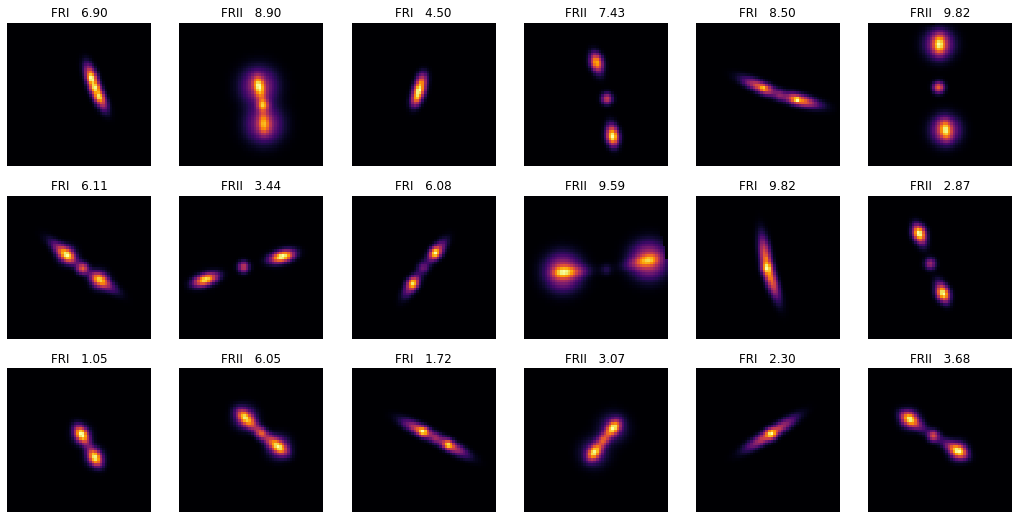

In [121]:
n = 18
synthetic_images1 = np.empty((n, 56, 56))
synthetic_labels1 = np.empty(n)
for i in range(n):
    synthetic_images1[i], synthetic_labels1[i] = sim_agn(i%2+1)

def show_labelled_images(images, labels, num=18, log=False):
    cols = 6
    rows = (num+cols-1)//cols
    plt.figure(figsize=(18,3*rows))
    for i in range(num):
        ax = plt.subplot(rows, cols, i+1)
        image = images[i]
        if log: 
            image = image-np.min(image)+0.01 # make all pixel values positive for log color scale
            plt.imshow(image, cmap='inferno', norm=colors.LogNorm())
        else:
            plt.imshow(image, cmap='inferno')
        type=['FRI', 'FRII']
        plt.title('{}   {:.2f}'.format(type[i%2], labels[i]))
        plt.axis('off')
    plt.show()
    
show_labelled_images(synthetic_images1, synthetic_labels1)

In [192]:
## Create dataset
import time

time1=time.time()

n = 18000
synthetic_images = np.empty((n, 56, 56))
synthetic_angles = np.empty(n)
for i in range(n):
    if i<6000: synthetic_images[i], synthetic_labels[i] = sim_agn(fr_type=1)
    elif i<12000: synthetic_images[i], synthetic_labels[i] = sim_agn(fr_type=2)
    elif i<18000: synthetic_images[i], synthetic_labels[i] = sim_agn(fr_type=3)
synthetic_labels = np.concatenate((np.zeros(6000), np.ones(6000), np.full(6000, 2)))
        
print('time taken = {:.2f}'.format(time.time()-time1))
per_im = (time.time()-time1)/n
print('time per image = {:.2f}'.format(per_im))

np.save('geo_sim_images.npy', synthetic_images)
np.save('geo_sim_labels.npy', synthetic_labels)
np.save('geo_sim_angles.npy', synthetic_angles)

time taken = 150.91
time per image = 0.01


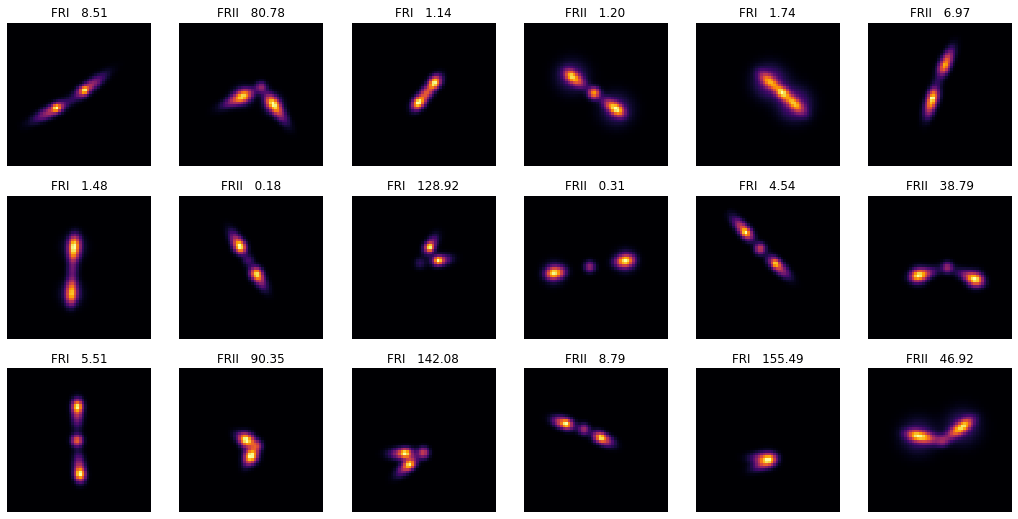

In [190]:
num = 18
cols = 6
rows = (num+cols-1)//cols
plt.figure(figsize=(18,3*rows))
for i in range(num):
    ax = plt.subplot(rows, cols, i+1)
    idx = np.random.randint(18000)
    image = synthetic_images[idx]
    plt.imshow(image, cmap='inferno')
    type=['FRI', 'FRII', 'bent']
    plt.title('{}   {:.2f}'.format(type[i%2], synthetic_labels[idx]))
    plt.axis('off')
plt.show()